# Input Data Preprocessing
This Jupyter notebook contains code to process weather station data into a single .csv from multiple messy files. Once you complete this script, move to process_AWS to complete the data cleaning process.

In [73]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Set-up: Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths.

In [74]:
# FILEPATHS
data_fp = '../climate_data/AWS/Raw/'                # Filepath to the folder of input data
folder = data_fp + 'naluday/'                       # Filepath of the folder containing the messy files
file_type = 'txt'                                   # Choose the file type (csv, txt or xlsx)

Time zone: UTC -420 minutes
Date_Time	Pressure_20290337_mbar	Temperature_20339015_deg_C	RH_20339015_%	Wind Speed_20339186_m/s	Gust Speed_20339186_m/s	Wind Direction_20339186_deg	SDI-12_SDI_0_0_na	SDI-12_SDI_0_1_na	SDI-12_SDI_0_2_na	SDI-12_SDI_0_3_na	

In [77]:
# Concatenate files in folder
fn_list = os.listdir(folder)
fn_list = [f for f in fn_list if file_type in f]
# 
col_names = ['DateTime','Pressure','Temperature','RH','Wind','Gust','Winddir','SWin','SWout','LWin','LWout']
for fn in fn_list:
    # Open the file
    df = pd.read_csv(folder + fn, index_col=0,          # Base arguments, assumes column 0 is the datetime
                            sep='\t',                   # Delimiter/separater
                            skiprows=3,                 # How many rows of metadata
                            encoding='ISO-8859-1',      # Encoding
                            engine='python',            # Engine to open the file
                            names = col_names)          # Specify the names of the columns
    
    # Get timezone
    with open(folder + fn, 'r') as f:
        lines = f.readlines()
    second_line = lines[1]
    zone_minutes = int(second_line.split('UTC')[-1].split(' ')[1])
    timezone = pd.Timedelta(minutes=zone_minutes)

    # Skip empty files
    if len(df.index) == 0:
        continue
    
    # Process the datetime column to be in the right format
    if len(str(df.index[0])) > 8:
        df.index = pd.to_datetime(df.index, format='%m/%d/%y %H:%M:%S') - timezone
    else:
        df.index = pd.to_datetime(df.index, format='%m/%d/%y') - timezone

    # Concatenate files
    if fn == fn_list[0]:
        df_all = df.copy(deep=True)
    else:
        df_all = pd.concat([df_all, df],axis=0)
df_all = df_all.sort_index()
df_all = df_all[pd.to_datetime(df_all.index).second == 0]
df_all

,Pressure,Temperature,RH,Wind,Gust,Winddir,SWin,SWout,LWin,LWout
DateTime,,,,,,,,,,
2019-08-28 18:00:00,15.796,-0.000,-0.000,-2.000,-2.000,NaN,NaN,NaN,NaN,NaN
2019-08-28 19:00:00,16.463,-0.000,-0.000,-2.000,-2.000,NaN,NaN,NaN,NaN,NaN
2019-08-29 20:00:00,20.984,0.016,20.562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-31 00:00:00,19.603,49.200,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-31 01:00:00,19.484,49.400,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-07-16 07:00:00,863.450,8.045,69.500,3.508,7.016,131.969,-1.56,0.01,329.74,353.92
2025-07-16 08:00:00,863.150,8.145,69.200,4.210,7.016,131.969,-2.05,0.00,324.64,351.10
2025-07-16 09:00:00,863.550,8.568,66.300,1.403,5.613,134.776,-1.82,0.04,331.53,351.61


## Inspect data fullness

This plot can help you decide whether to process the data all together or split it into separate files (e.g., if there is a large data gap)

In [78]:
# Print data counts
df_all.count()

Pressure       50164
Temperature    50164
RH             50164
Wind           50163
Gust           50125
Winddir        50123
SWin           32974
SWout          36289
LWin           37272
LWout          37272
dtype: int64

In [ ]:
# df_all = df_all.drop(columns=['SWout','LWout'])

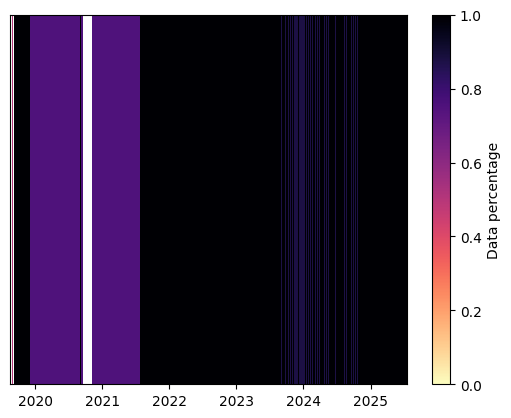

In [66]:
plot = False
if plot:
    fig, ax = plt.subplots()
    all_percentage = []
    for row in df_all.index:
        percent = df_all.loc[row].count() / len(df_all.columns)
        all_percentage.append(percent)
    cmap = plt.get_cmap('magma_r')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    ax.bar(df_all.index, 1, pd.Timedelta(hours=1), color=cmap(norm(all_percentage)))
    ax.set_xlim(df_all.index[0], df_all.index[-1])
    ax.set_ylim(0,1)
    ax.set_yticks([])
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Data percentage',orientation='vertical')
    plt.show()

In [ ]:
def find_data_periods(df, min_months=4, coverage_threshold=0.9):
    df = df.sort_index()
    min_hours = int(min_months * 30 * 24)  # ~4 months in hours

    # Mask: only rows where all variables are present
    is_complete = df.notna().all(axis=1)

    # Group by breaks in continuity
    block_ids = (~is_complete).cumsum()
    blocks = df[is_complete].groupby(block_ids)

    results = []
    for _, block in blocks:
        if len(block) < min_hours:
            continue

        start_ok = block.iloc[0].notna().all()
        end_ok = block.iloc[-1].notna().all()
        print(block.iloc[0]['Wind'])

        coverage = block.notna().sum().sum() / block.size

        if block.index[0].second != 0:
            block = block.iloc[1:]
        if block.index[-1].second != 0:
            block = block.iloc[:-1]

        if start_ok and end_ok and coverage >= coverage_threshold:
            results.append((block.index[0], block.index[-1]))

    print(f'Found {len(results)} continuous periods')
    return results

blocks = find_data_periods(df_all)
print(blocks)

20.659
True True 2021-07-25 08:00:00
0.0
True True 2024-11-01 15:00:00
Found 2 continuous periods
[(Timestamp('2021-07-25 08:00:00'), Timestamp('2023-08-08 05:00:00')), (Timestamp('2024-11-01 15:00:00'), Timestamp('2025-07-16 11:00:00'))]


In [80]:
# Fill random missing timestamps with Nans (will be interpolated out in processing)
dfs = []
for b,block in enumerate(blocks):
    time = pd.date_range(block[0], block[1], freq='h')
    block_df = df_all.reindex(time)
    dfs.append(block_df.loc[time])
    print(f'Total n points in block {b}: ',len(block_df.index))
    dfs[-1].count()

Total n points in block 0:  17854
Total n points in block 1:  6165


In [81]:
for d,df in enumerate(dfs):
    start_year = df.index[0].year
    fn = folder + f'preprocessed_{start_year}.csv'
    df.to_csv(fn)
    print(f'Saved dataframe {d} to {fn}: {df.index[0].date()} to {df.index[-2].date()}')

Saved dataframe 0 to ../climate_data/AWS/Raw/naluday/preprocessed_2021.csv: 2021-07-25 to 2023-08-08
Saved dataframe 1 to ../climate_data/AWS/Raw/naluday/preprocessed_2024.csv: 2024-11-01 to 2025-07-16
